## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [19]:
! pip install tensorflow==2.12.0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow e Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#Scikit-Learn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    ConfusionMatrixDisplay, multilabel_confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

#Imbalanced-Learn
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler





**QUESTION:** Load dataset and display some lines of the csv file.

In [20]:
data_path = "/content/ai4i2020.csv"

df = pd.read_csv(data_path)

df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

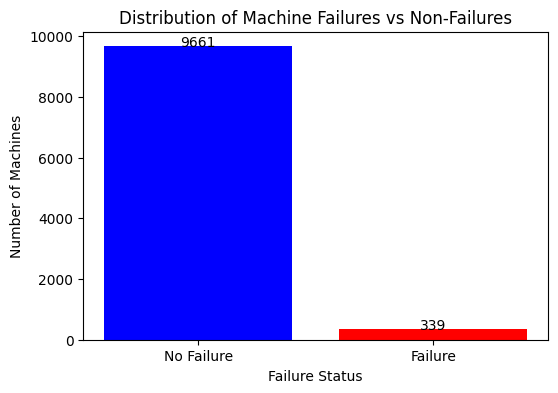

In [21]:

counts_machine_failure = df['Machine failure'].value_counts()

labels = ['No Failure', 'Failure']
values = [counts_machine_failure.get(0, 0), counts_machine_failure.get(1, 0)]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['blue', 'red'])
plt.title("Distribution of Machine Failures vs Non-Failures")
plt.xlabel("Failure Status")
plt.ylabel("Number of Machines")

for i, v in enumerate(values):
    plt.text(i, v + 0.5, str(int(v)), ha='center')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

O sistema apresenta um baixa quantidade percentual de falhas (3,39 %).


**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Como os dados não estão bem distribuidos entre falha e não falha, o modelo provavelmente vai acertar mais quando não houver uma falha em comparação a quando houver uma falha.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

<ipython-input-22-235485598937>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette=['blue', 'orange', 'green', 'red', 'purple'] )


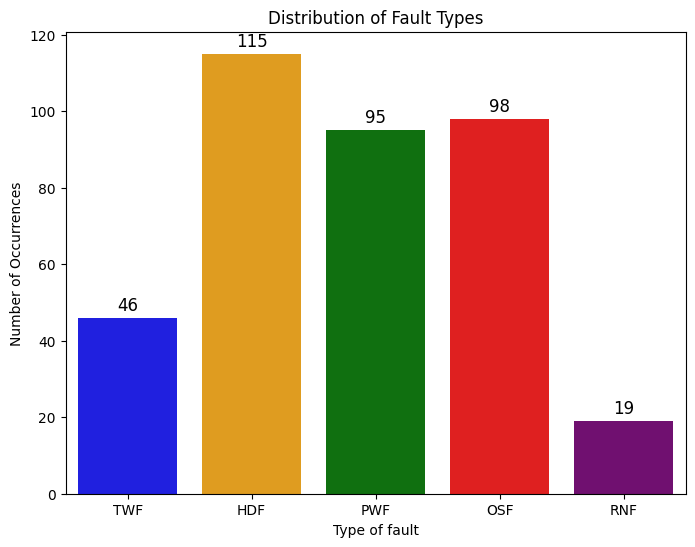

In [22]:
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = df[failure_types].sum()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette=['blue', 'orange', 'green', 'red', 'purple'] )

for i, value in enumerate(failure_counts.values):
    ax.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.xlabel("Type of fault")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Fault Types")

plt.show()

**ANALYSIS QUESTION:** What do you observe?

Pode-se observar que existe uma maior ocorrência das falhas do tipo HDF, PWF e OSF em comparação as do tipo TWF e RNF. Vale ressaltar, que a soma das falhas de cada tipo obtemos um valor total de 373 falhas, no entanto como observado no primeiro gráfico ("Distribution of Faults and Non-Faults in the Machine") há um total de 339 falhas. Isso ocorre por conta de certas máquinas possuírem falhas simultaneas, além disso as falhas aleatórias (RNF) não são contabilizadas como falhas.



**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

<ipython-input-23-708757154ff1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=failure_counts.index, y=failure_counts.values,  palette=['blue', 'orange', 'green', 'red', 'purple', 'gray'])


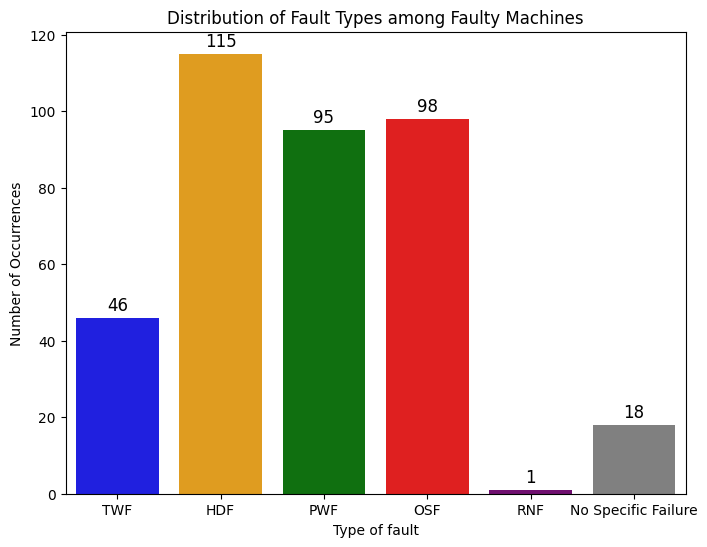

In [23]:
failed_machines = df[df["Machine failure"] == 1]

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = failed_machines[failure_types].sum()

no_specific_failure = df[(df["Machine failure"] == 0) & (df["RNF"] == 1)].shape[0]

failure_counts["No Specific Failure"] = no_specific_failure

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=failure_counts.index, y=failure_counts.values,  palette=['blue', 'orange', 'green', 'red', 'purple', 'gray'])

for i, value in enumerate(failure_counts.values):
    ax.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.xlabel("Type of fault")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Fault Types among Faulty Machines")

plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Como já mencionado, as falhas do tipo aleatório nao são contabilizadas na coluna "Machine Failure", dessa forma a barra "No Specific Failure" foi criada para comtemplar esses casos. No gráfico anterior foram contabilizadas 19 falhas "RNF", no entando, no gráfico atual existem 18 falhas "No Specific Failure" (que são falhas "RNF" não contabilizadas) e 1 uma falha "RNF", essa falha só foi contabilizada pois existe uma outra falha simultanea.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [24]:
print("Column Names and Data Types:")
print(df.dtypes)

Column Names and Data Types:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Para treinar o modelo, as entradas escolhidas serão as variáveis que indicam o uso da máquina e situação fisica dela, como Air temperature, Process temperature, Rotational speed, Torque, Tool wear e Type, pois influenciam diretamente no desempenho e possíveis falhas. As saídas
serão Machine failure e as colunas com os tipos de falhas como TWF, HDF, PWF e OSF, retirei RNF pois sua quantidade é irrisória em comparação com as outras falhas e principalmente porque são falhas aleatórias. Isso acarreta em uma previsão sobre os possiveis problemas além de permitir ações de manutenção preditiva baseadas nas condições da máquina.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [25]:
# Criar variáveis dummies para a coluna 'Type'
df = pd.get_dummies(df, columns=['Type'], drop_first=False)


In [26]:
#  Tipos de falha
failure_types = ['TWF', 'HDF', 'PWF', 'OSF']

#  Remover amostras com mais de uma falha específica
df['sum_failures'] = df[failure_types].sum(axis=1)
df = df[(df['Machine failure'] == 0) | ((df['Machine failure'] == 1) & (df['sum_failures'] == 1))]
df.drop(columns='sum_failures', inplace=True)

#  Criar coluna "No failure"
df['No failure'] = (df['Machine failure'] == 0).astype(int)

#  Criar colunas one-hot exclusivas: apenas uma será 1 por linha
# Copiar as colunas como base de Y
Y = df[['No failure', 'TWF', 'HDF', 'PWF', 'OSF']].copy()

# Garantir que somente uma coluna tenha 1 por linha
# (Reforço de segurança para garantir consistência)
Y = Y.apply(lambda row: (row == 1).astype(int), axis=1)

#  Definir X (remover colunas de saída e irrelevantes)
df = df.drop(columns=['class'], errors='ignore')
X = df.drop(columns=['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'No failure'])

# Normalizar X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

#  Dividir treino/teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y.values.argmax(axis=1))

#  Exibir dimensões
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

#  Conferir as primeiras linhas
print(Y_train.head())

print(X.head())
print(Y.head())

X_train shape: (6977, 8), Y_train shape: (6977, 5)
X_test shape: (2991, 8), Y_test shape: (2991, 5)
      No failure  TWF  HDF  PWF  OSF
5781           1    0    0    0    0
8589           1    0    0    0    0
832            1    0    0    0    0
5331           1    0    0    0    0
7660           1    0    0    0    0
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0             0.304348                 0.358025                0.222934   
1             0.315217                 0.370370                0.139697   
2             0.304348                 0.345679                0.192084   
3             0.315217                 0.358025                0.154249   
4             0.315217                 0.370370                0.139697   

   Torque [Nm]  Tool wear [min]  Type_H  Type_L  Type_M  
0     0.535714         0.000000     0.0     0.0     1.0  
1     0.583791         0.011952     0.0     1.0     0.0  
2     0.626374         0.019920     0.0     1.0     0

Número de amostras com apenas uma falha específica: 307


<ipython-input-27-f2f0ac6f9469>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=remaining_failure_counts.index, y=remaining_failure_counts.values,


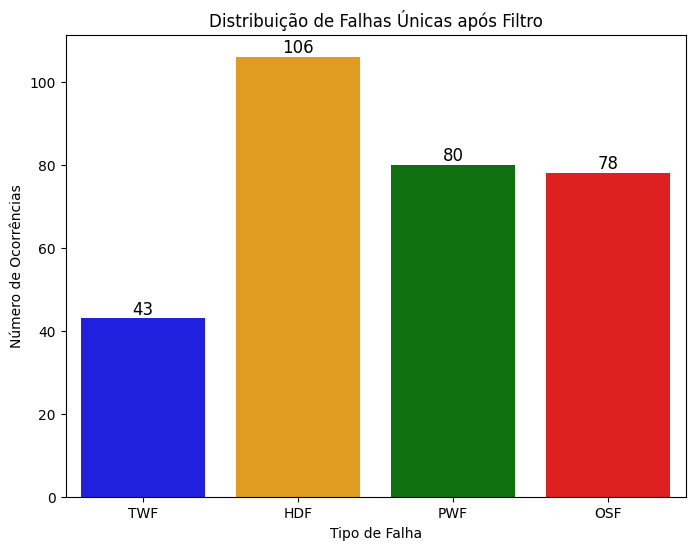

In [27]:
# Tipos de falha específicos
failure_types = ['TWF', 'HDF', 'PWF', 'OSF']

# Criar coluna com a soma das falhas por linha
df['sum_failures'] = df[failure_types].sum(axis=1)

# Filtrar apenas máquinas com falha E uma única falha específica
filtered_failures = df[(df['Machine failure'] == 1) & (df['sum_failures'] == 1)]

# Contar quantas amostras únicas restaram
num_remaining = filtered_failures.shape[0]
print(f"Número de amostras com apenas uma falha específica: {num_remaining}")

# Contar quantas de cada tipo de falha existem nas amostras filtradas
remaining_failure_counts = filtered_failures[failure_types].sum()

# Plotar a distribuição dos tipos de falha
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=remaining_failure_counts.index, y=remaining_failure_counts.values,
                 palette=['blue', 'orange', 'green', 'red'])

# Adicionar os valores acima das barras
for i, value in enumerate(remaining_failure_counts.values):
    ax.text(i, value + 1, str(int(value)), ha='center', fontsize=12)

plt.xlabel("Tipo de Falha")
plt.ylabel("Número de Ocorrências")
plt.title("Distribuição de Falhas Únicas após Filtro")
plt.show()

# Remover a coluna auxiliar
df.drop(columns='sum_failures', inplace=True)






**QUESTION** Code below the model architecture

In [28]:
# Modelo para classificação multi-classe (5 saídas exclusivas)
model = Sequential([
    Dense(64, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Dense(32, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    Dense(5, activation='softmax')  # Agora usamos softmax para multi-classe exclusiva
])

# Compilação com categorical_crossentropy
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.02),
    loss='categorical_crossentropy',           # one-hot multi-class
    metrics=['accuracy']
)

# Exibir o resumo
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                576       
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/50
110/110 [==============================] - 6s 16ms/step - loss: 1.7072 - accuracy: 0.5444 - val_loss: 1.2672 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - 1s 8ms/step - loss: 0.7883 - accuracy: 0.9227 - val_loss: 0.6671 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - 1s 8ms/step - loss: 0.5133 - accuracy: 0.9538 - val_loss: 0.4235 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 4/50
110/110 [==============================] - 1s 8ms/step - loss: 0.3865 - accuracy: 0.9613 - val_loss: 0.3079 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 5/50
110/110 [==============================] - 2s 15ms/step - loss: 0.3160 - accuracy: 0.9640 - val_loss: 0.2475 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 6/50
110/110 [==============================] - 2s 16ms/step - loss: 0.2608 - accuracy: 0.9657 - val_loss: 0.2149 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 7/50
110/110 [==============================] - 1s 11ms/step 

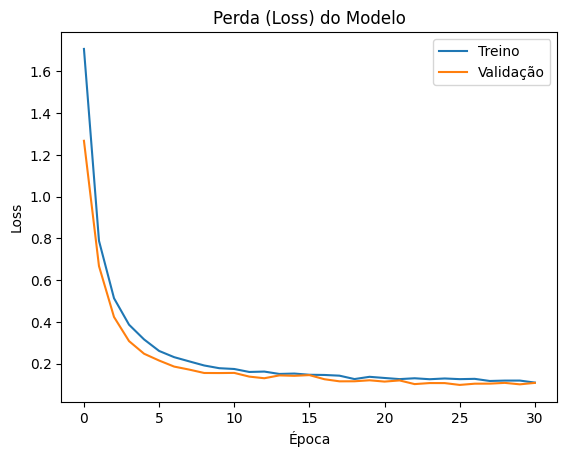

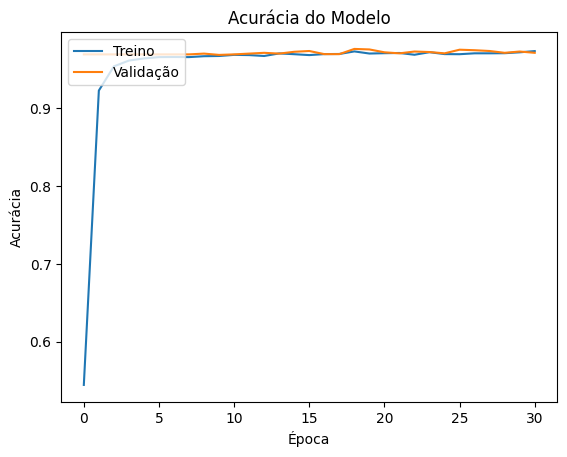

In [29]:

#  Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

#  Treinar o modelo
history = model.fit(
    X_train, Y_train,                         # Y_train one-hot (5 colunas)
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

#  Função para plotar métricas
def plot_metric(history, metric, title, ylabel, loc='upper left'):
    if metric in history.history:
        plt.plot(history.history[metric], label='Treino')
    if f'val_{metric}' in history.history:
        plt.plot(history.history[f'val_{metric}'], label='Validação')

    plt.title(title)
    plt.xlabel('Época')
    plt.ylabel(ylabel)
    plt.legend(loc=loc)
    plt.show()

#  Plotar as curvas
plot_metric(history, 'loss', 'Perda (Loss) do Modelo', 'Loss', loc='upper right')
plot_metric(history, 'accuracy', 'Acurácia do Modelo', 'Acurácia')


**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





94/94 [==============================] - 0s 1ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

  No failure       0.98      1.00      0.99      2899
         TWF       0.00      0.00      0.00        13
         HDF       0.00      0.00      0.00        32
         PWF       0.86      0.25      0.39        24
         OSF       1.00      0.61      0.76        23

    accuracy                           0.98      2991
   macro avg       0.57      0.37      0.43      2991
weighted avg       0.96      0.98      0.97      2991



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


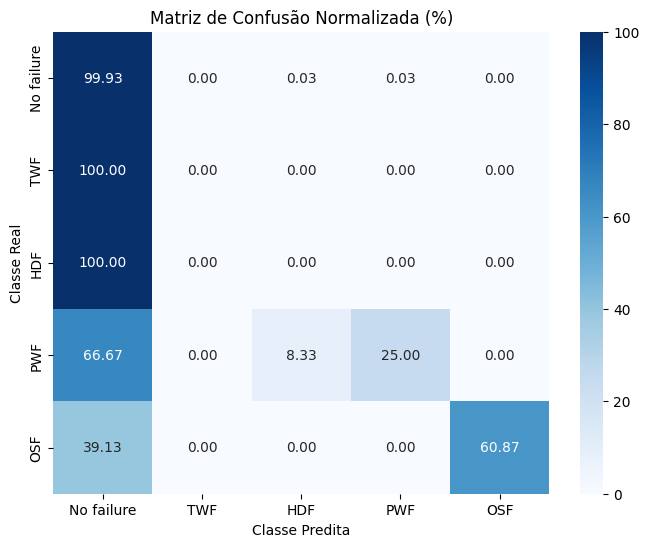

In [30]:

#  Fazer predições em probabilidades
Y_pred_probs = model.predict(X_test)

#  Obter a classe com maior probabilidade (softmax) → previsão final
Y_pred = Y_pred_probs.argmax(axis=1)

#  Obter as classes reais
Y_true = Y_test.values.argmax(axis=1)

#  Rótulos das classes
labels = ['No failure', 'TWF', 'HDF', 'PWF', 'OSF']

#  Gerar relatório de classificação
report = classification_report(Y_true, Y_pred, target_names=labels)
print("\nRelatório de Classificação:")
print(report)

#  Criar matriz de confusão
cm = confusion_matrix(Y_true, Y_pred)

#  Normalizar por linha (percentual por classe real)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

#  Plotar a matriz de confusão 5x5
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.title("Matriz de Confusão Normalizada (%)")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.show()


**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [31]:
#  Seu código com undersampling (mantido igual)
undersampler = RandomUnderSampler(sampling_strategy=0.3, random_state=42)
X_resampled, y_no_failure = undersampler.fit_resample(X, Y['No failure'])
selected_indices = y_no_failure.index
Y_resampled = Y.iloc[selected_indices].copy()
Y_resampled = Y_resampled.apply(lambda row: (row == 1).astype(int), axis=1)

#  Dividir com estratificação
X_train_under, X_test_under, Y_train_under, Y_test_under = train_test_split(
    X_resampled, Y_resampled, test_size=0.2, random_state=42,
    stratify=Y_resampled.values.argmax(axis=1)
)

# Calcular class weights automaticamente
y_integers = Y_train_under.values.argmax(axis=1)
classes = np.unique(y_integers)

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_integers)
class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}

#  Exibir os pesos
print("Pesos calculados para class_weight:", class_weight_dict)


Pesos calculados para class_weight: {0: 0.2601466992665037, 1: 6.08, 2: 2.503529411764706, 3: 3.325, 4: 3.432258064516129}


<ipython-input-32-31d4fef3c45b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=remaining_failure_counts.index, y=remaining_failure_counts.values,


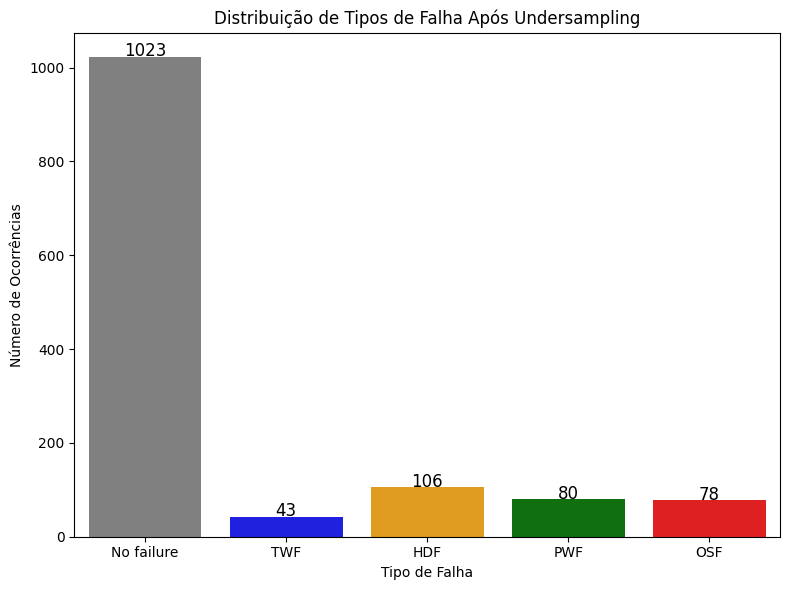

In [32]:
# Lista de colunas de falhas
failure_types = ['TWF', 'HDF', 'PWF', 'OSF']
all_classes = ['No failure'] + failure_types

# Contar quantas amostras por classe (coluna com valor 1)
remaining_failure_counts = Y_resampled[all_classes].sum()

# Plotar
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=remaining_failure_counts.index, y=remaining_failure_counts.values,
                 palette=['gray', 'blue', 'orange', 'green', 'red'])

# Adicionar os valores acima das barras
for i, value in enumerate(remaining_failure_counts.values):
    ax.text(i, value + 1, str(int(value)), ha='center', fontsize=12)

plt.xlabel("Tipo de Falha")
plt.ylabel("Número de Ocorrências")
plt.title("Distribuição de Tipos de Falha Após Undersampling")
plt.tight_layout()
plt.show()




**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [33]:
# Modelo para classificação multi-classe (5 saídas exclusivas)
model = Sequential([
    Dense(64, kernel_regularizer=l2(0.01), input_shape=(X_train_under.shape[1],)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Dense(32, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),

    Dense(5, activation='softmax')  # Agora usamos softmax para multi-classe exclusiva
])

# Compilação com categorical_crossentropy
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.02),
    loss='categorical_crossentropy',           # one-hot multi-class
    metrics=['accuracy']
)

# Exibir o resumo
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                576       
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_7 (Batc  (None, 32)               128       
 hNormalization)                                      

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/50
17/17 [==============================] - 7s 90ms/step - loss: 2.4685 - accuracy: 0.1382 - val_loss: 2.2925 - val_accuracy: 0.1128 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - 0s 17ms/step - loss: 2.2192 - accuracy: 0.1711 - val_loss: 2.2576 - val_accuracy: 0.1128 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - 0s 14ms/step - loss: 1.9227 - accuracy: 0.1992 - val_loss: 2.2096 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - 0s 9ms/step - loss: 1.7524 - accuracy: 0.2538 - val_loss: 2.1578 - val_accuracy: 0.1654 - lr: 0.0010
Epoch 5/50
17/17 [==============================] - 0s 10ms/step - loss: 1.7674 - accuracy: 0.2632 - val_loss: 2.1118 - val_accuracy: 0.1692 - lr: 0.0010
Epoch 6/50
17/17 [==============================] - 0s 11ms/step - loss: 1.7058 - accuracy: 0.2904 - val_loss: 2.0594 - val_accuracy: 0.1767 - lr: 0.0010
Epoch 7/50
17/17 [==============================] - 0s 10ms/step - loss: 1.54

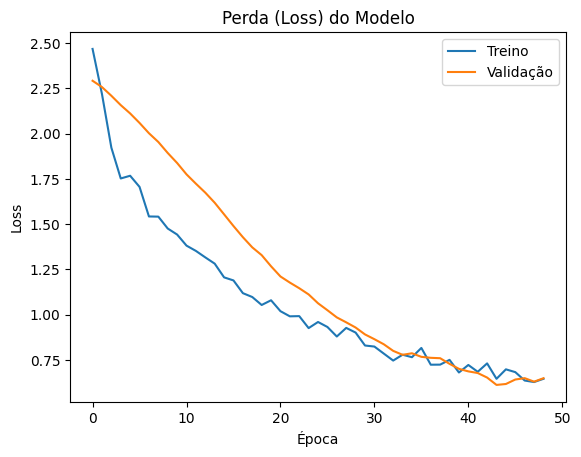

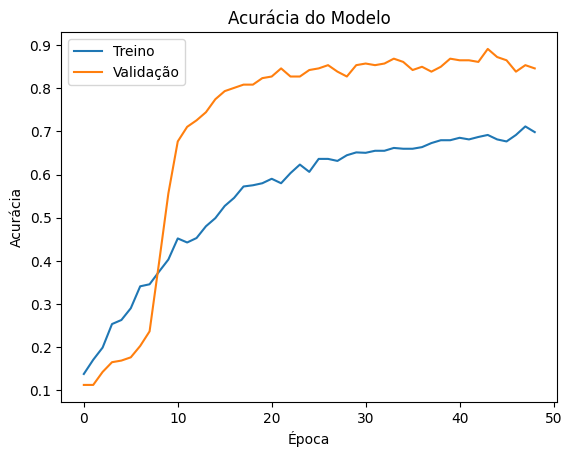

In [34]:

#  Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

#  Treinar o modelo
history = model.fit(
    X_train_under,
    Y_train_under,
    validation_data=(X_test_under, Y_test_under),
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

#  Função para plotar métricas
def plot_metric(history, metric, title, ylabel, loc='upper left'):
    if metric in history.history:
        plt.plot(history.history[metric], label='Treino')
    if f'val_{metric}' in history.history:
        plt.plot(history.history[f'val_{metric}'], label='Validação')

    plt.title(title)
    plt.xlabel('Época')
    plt.ylabel(ylabel)
    plt.legend(loc=loc)
    plt.show()

#  Plotar as curvas
plot_metric(history, 'loss', 'Perda (Loss) do Modelo', 'Loss', loc='upper right')
plot_metric(history, 'accuracy', 'Acurácia do Modelo', 'Acurácia')

np.save('X_test_labels.npy', 'X_test_under')
np.save('Y_test_labels.npy', 'Y_test_under')
model.save('model_test.h5')

**QUESTION** Plot the confusion matrix and the classification report

9/9 [==============================] - 0s 4ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

  No failure       1.00      0.87      0.93       205
         TWF       0.35      1.00      0.52         8
         HDF       0.83      0.95      0.89        21
         PWF       0.76      1.00      0.86        16
         OSF       0.75      0.94      0.83        16

    accuracy                           0.89       266
   macro avg       0.74      0.95      0.81       266
weighted avg       0.94      0.89      0.90       266



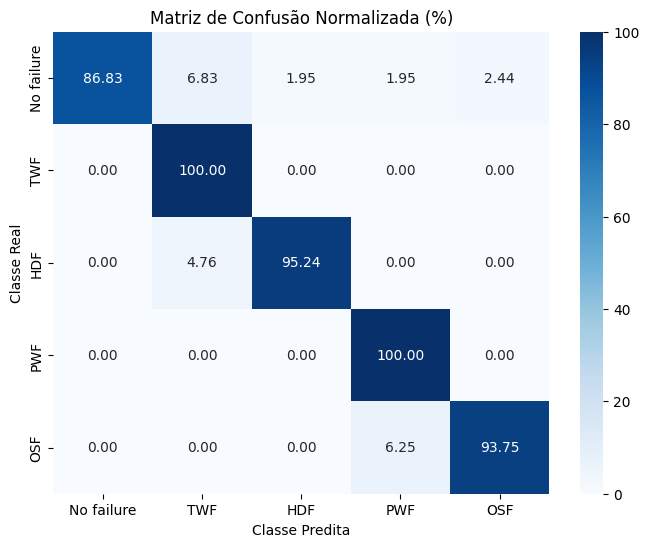

In [35]:

#  Fazer predições em probabilidades
Y_pred_probs = model.predict(X_test_under)

#  Obter a classe com maior probabilidade (softmax) → previsão final
Y_pred = Y_pred_probs.argmax(axis=1)

#  Obter as classes reais
Y_true = Y_test_under.values.argmax(axis=1)

#  Rótulos das classes
labels = ['No failure', 'TWF', 'HDF', 'PWF', 'OSF']

#  Gerar relatório de classificação
report = classification_report(Y_true, Y_pred, target_names=labels)
print("\nRelatório de Classificação:")
print(report)

#  Criar matriz de confusão
cm = confusion_matrix(Y_true, Y_pred)

#  Normalizar por linha (percentual por classe real)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

#  Plotar a matriz de confusão 5x5
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.title("Matriz de Confusão Normalizada (%)")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.show()


**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"